# Selección y extracción de atributos
**Autor:** José A. Troyano &nbsp;&nbsp;&nbsp; **Revisor:** Beatriz Pontes  &nbsp;&nbsp;&nbsp; **Última modificación:** 17/04/2023

---------------------------------------------------------
## Contenido


1. <a href="#dataset">Dataset y procedimiento de evaluación</a> <br>
    1.1 <a href="#ruido">Generación de atributos con ruido</a> <br>
    1.2 <a href="#experimento">Diseño de los experimentos</a>
2. <a href="#univariante">Selección univariante</a> <br>
    2.1 <a href="#anova">Test ANOVA</a> <br>
    2.2 <a href="#otros">Otros tests disponibles en Sklearn</a>
3. <a href="#estimadores">Selección de atributos basada en estimadores</a><br>
    3.1 <a href="#arboles">Mediante árboles</a><br>
    3.2 <a href="#coeficientes">Mediante coeficientes de modelos lineales</a><br>
    3.3 <a href="#pipelines">_Pipelines_ para encadenar selección y clasificación</a><br>
4. <a href="#pca">Extracción de atributos mediante análisis de componentes principales</a><br>
5. <a href="#rfe">Selección de atributos por eliminación recursiva</a><br>
6. <a href="#conclusiones">Conclusiones</a>
------------------------------------------------------

En este notebook veremos cómo reducir el número de atributos de nuestro dataset. Lucharemos con lo que se conoce como _curse of dimensionality_ que tiene básicamente estos efectos:
- Cuando aumenta la dimensionalidad, el volumen del espacio aumenta exponencialmente haciendo que los datos disponibles se vuelvan dispersos. 
- Esta dispersión impide que los algoritmos de aprendizaje puedan construir buenos modelos.

La selección y extracción de atributos son dos estrategias típicas para luchar con la maldición de la dimensionalidad. Se basan, respectivamente, en la elección de un buen subconjunto de atributos y en la construcción de nuevos atributos a partir de los originales.

Empezaremos por importar todos los elementos que usaremos a lo largo del notebook:

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import RFE
from sklearn.feature_selection import f_classif, mutual_info_classif, chi2
from sklearn.feature_selection import SelectPercentile, SelectKBest, SelectFromModel

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\valle\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## 1. Dataset y procedimiento de evaluación <a name="dataset"> </a>

Usaremos el dataset _breast-cancer_, disponible en Sklearn que tiene:
- 569 instancias
- 30 atributos numéricos
- Una clase discreta con dos posibles valores

In [2]:
# Empezaremos por leer el dataset desde Sklearn y crear 'X' e 'y'
DATOS = load_breast_cancer()
X = pd.DataFrame(DATOS['data'], columns=DATOS['feature_names'])
y = pd.Series(DATOS['target'])
print(y.describe())
print(X.info())

count    569.000000
mean       0.627417
std        0.483918
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error

### 1.1. Generación de atributos con ruido <a name="ruido"> </a>


Para asegurarnos que hay atributos que deben ser eliminados crearemos una versión ofuscada de este dataset con 30 columnas aleatorias. Esta versión presenta, por tanto, estos números:
- 569 instancias
- 60 atributos numéricos
- Una clase discreta con dos posibles valores

Si quisiésemos probar todas los posibles subconjuntos de 60 atributos para encontrar el mejor, tendríamos que probar $2^{60}$ combinaciones, que nos da un total de $11 \times 10^{17}$ experimentos. Si cada experimento durase un segundo, tendríamos que esperar 36.000 millones de años para ejecutarlos todos. Gracias a la selección y extracción de atributos tenemos estrategias para encontrar un buen conjunto de atributos (no el mejor) en un tiempo razonable.

In [3]:
# Generaremos una matriz 'X_RUIDOSOS' que contenga las columnas de 'X' junto con 30 columnas aleatorias. Para generar los atributos aleatorios:
#   - Usamos np.random.RandomState(100) como objeto semilla
#   - Usamos una distribución uniforme para generar valores entre 0 y 50           
semilla_aleatoria = np.random.RandomState(100)
DATOS_RUIDOSOS= semilla_aleatoria.uniform(0, 50, size=(len(X), 30))
nombres = ['R-'+str(i) for i in range(30)]
DATOS_RUIDOSOS = pd.DataFrame(DATOS_RUIDOSOS, columns=nombres)
X_RUIDOSOS = pd.concat([X, DATOS_RUIDOSOS], axis=1)
print(X_RUIDOSOS.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

### 1.2. Diseño de los experimentos

La función <code>evalua</code> realiza la evaluación de un clasificador (por defecto <code>LogisticRegresion</code>) sobre un dataset:

In [4]:
# Evaluamos ambos datasets para tener los baselines
def evalua(X, y, clasificador=LogisticRegression()):
    ''' Función para evaluar un dataset mediante validación cruzada
    
    Por defecto se usa el clasificador LogisticRegression, aunque se puede cambiar.
    '''
    scores = cross_val_score(clasificador, X, y, cv=10)
    return scores.mean()

Empezamos por evaluar <code>X</code> y <code>X_RUIDOSOS</code> para tener así una referencia del efecto de las distintas técnicas de selección de atributos que vamos a probar:

In [5]:
# Evaluamos ambos datasets para tener los baselines y creamos el dataframe RESULTADOS
RESULTADOS = pd.DataFrame(columns=['X', 'Mejora para X', 'X_RUIDOSOS', 'Mejora para X_RUIDOSOS'])

RESULTADOS.loc['Sin selección'] = (evalua(X,y), '--', evalua(X_RUIDOSOS,y), '--')
RESULTADOS

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

,X,Mejora para X,X_RUIDOSOS,Mejora para X_RUIDOSOS
Sin selección,0.943797,--,0.906924,--


In [6]:
# La siguiente función nos permitirá evaluar la mejora conseguida por un determinado selector sobre los datasets X y X_RUIDOSOS
#     PARÁMETROS:
#       - selector: estimador usado en la selección para el experimento
#       - X: matriz de atributos original
#       - X_ruidosos: matriz de atributos ruidosos
#       - y: vector de salida
#    VARIABLES INTERMEDIAS:
#       - X_seleccion: resultado de aplicar el selector a X
#       - X_ruidosos_seleccion: resultado de aplicar el selector a X_ruidosos
#    RESULTADO: tupla con los siguientes valores
#       - Resultado de: evalua(X_seleccion, y)
#       - Resultado de: evalua(X, y) - evalua(X_seleccion, y)
#       - Resultado de: evalua(X_ruidosos_seleccion, y)
#       - Resultado de: evalua(X_ruidosos, y) - evalua(X_ruidosos_seleccion, y)

def experimento_seleccion(selector, X, X_ruidosos, y):
    X_seleccion = selector.fit_transform(X, y)
    X_ruidosos_seleccion = selector.fit_transform(X_ruidosos, y)
    return (evalua(X_seleccion, y), evalua(X_seleccion, y) -  evalua(X, y),
            evalua(X_ruidosos_seleccion, y), evalua(X_ruidosos_seleccion, y)-evalua(X_ruidosos, y))

Por último, en la siguiente celda se incluyen un par de funciones que nos ayudarán a interpretar los resultados de las distintas técnicas de selección de atributos que vamos a usar:

In [7]:
def muestra_relevancias(nombres, relevancias):
    '''Función para mostrar una gráfica con el grado de relevancia de cada atributo
    
    Recibe:
       - nombres: nombres de todos los atributos
       - relevancias: de cada atributo, calculadas mediante alguna técnica
    '''
    plt.figure(figsize=(len(nombres)/4,5))
    serie = pd.Series(relevancias, index=nombres)
    serie.plot(kind='bar')
    
def muestra_seleccion(nombres, mascara):
    '''Función para mostrar los nombres de los atributos seleccionados a partir de una máscara de booleanos
    
    Recibe:
       - nombres: nombres de todos los atributos
       - mascara: lista de booleanos que determina si un atributo se selecciona, o no
    '''    
    seleccionados = [n for n,m in zip(nombres, mascara) if m]
    print(len(seleccionados), seleccionados)

## 2. Selección univariante <a name="univariante"> </a>

En esta sección veremos formas de valorar qué importancia tiene cada atributo de forma individual. Para ello nos apoyaremos en tests estadísticos que miden la relación de cada atributo con la clase a predecir (o valor numérico en caso de regresión). Estos tests se diseñan para rechazar la siguiente hipótesis nula:

- $H_0$: el atributo no es relevante.

En <code>sklearn</code> estos tests se implementan mediante funciones que producen dos valores:
- **Estadístico**: una medida numérica que se calcula a partir de los datos, que se utiliza para tomar una decisión sobre la hipótesis nula (el atributo no es relevante). 
- **P-valor**: la probabilidad de no poder rechazar la hipótesis nula. Cuanto más bajo sea el *p-valor* es menos probable es que el resultado del test se deba al azar, y es más probable que haya un efecto real (que el atributo sea relevante).

Podemos usar cualquiera de los dos como criterio de selección, ambos nos ofrencen el mismo *ranking* de atributos.


### 2.1. Test ANOVA <a name="anova"> </a>

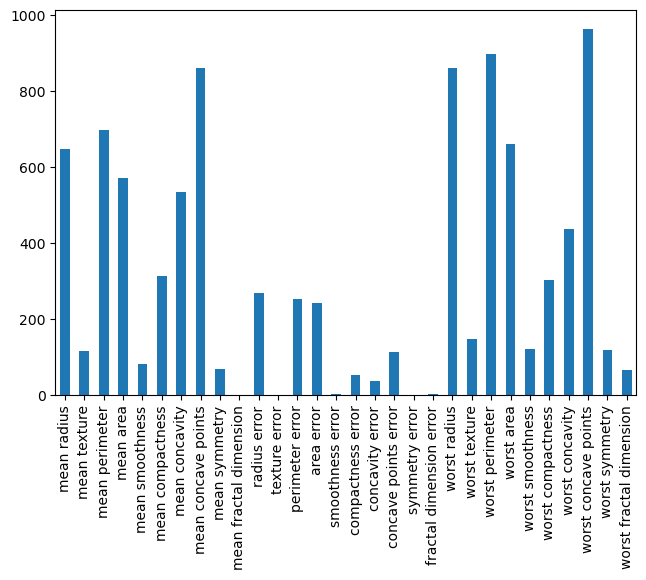

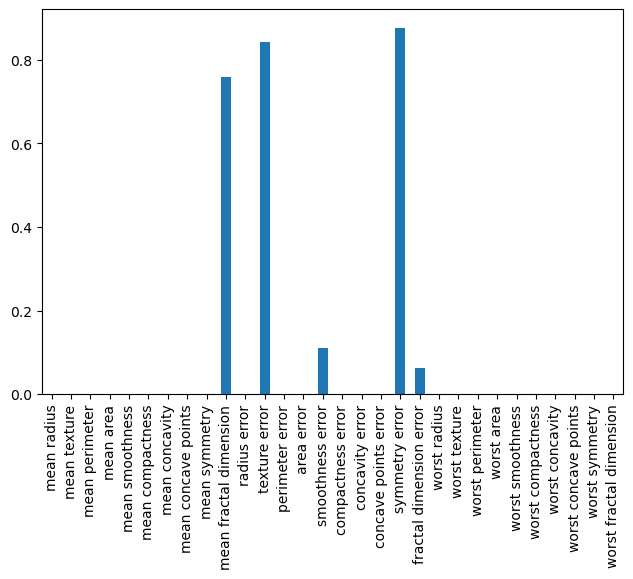

In [27]:
# EJERCICIO: mostrar el grado de relevancia de cada atributo del datastet X mediante el test ANOVA

# chatty - Calcular las puntuaciones de relevancia utilizando el test ANOVA
scores_anova = f_classif(X, y)[0]

# clase - Calcular las puntuaciones de relevancia utilizando el test ANOVA
fvalues, pvalues = f_classif(X, y)

#fvalues: importa valor bajo
#pvalue: importa valor alto

# Llamar a la función muestra_relevancias para visualizar los resultados
#muestra_relevancias(X.columns, scores_anova)
muestra_relevancias(X.columns, fvalues)
muestra_relevancias(X.columns, pvalues)

In [9]:
# EJERCICIO: mostrar los atributos de X cuyos pvalues obtenidos por el test ANOVA sean menores o iguales que 0.05

# Calcular los p-values utilizando el test ANOVA
pvalues_anova = f_classif(X, y)[1]

# Filtrar los nombres de los atributos cuyos p-values sean menores o iguales a 0.05
atributos_significativos = X.columns[pvalues_anova <= 0.05]

# Mostrar los atributos significativos
print("Atributos significativos según el test ANOVA:")
for atributo in atributos_significativos:
    print(atributo)


Atributos significativos según el test ANOVA:
mean radius
mean texture
mean perimeter
mean area
mean smoothness
mean compactness
mean concavity
mean concave points
mean symmetry
radius error
perimeter error
area error
compactness error
concavity error
concave points error
worst radius
worst texture
worst perimeter
worst area
worst smoothness
worst compactness
worst concavity
worst concave points
worst symmetry
worst fractal dimension


In [10]:
# EJERCICIO: mostrar los atributos de X cuyos pvalues obtenidos por el test ANOVA sean mayores que 0.05

# Calcular los p-values utilizando el test ANOVA
pvalues_anova = f_classif(X, y)[1]

# Filtrar los nombres de los atributos cuyos p-values sean mayores que 0.05
atributos_significativos = X.columns[pvalues_anova > 0.05]

# Mostrar los atributos significativos
print("Atributos significativos según el test ANOVA:")
for atributo in atributos_significativos:
    print(atributo)

Atributos significativos según el test ANOVA:
mean fractal dimension
texture error
smoothness error
symmetry error
fractal dimension error


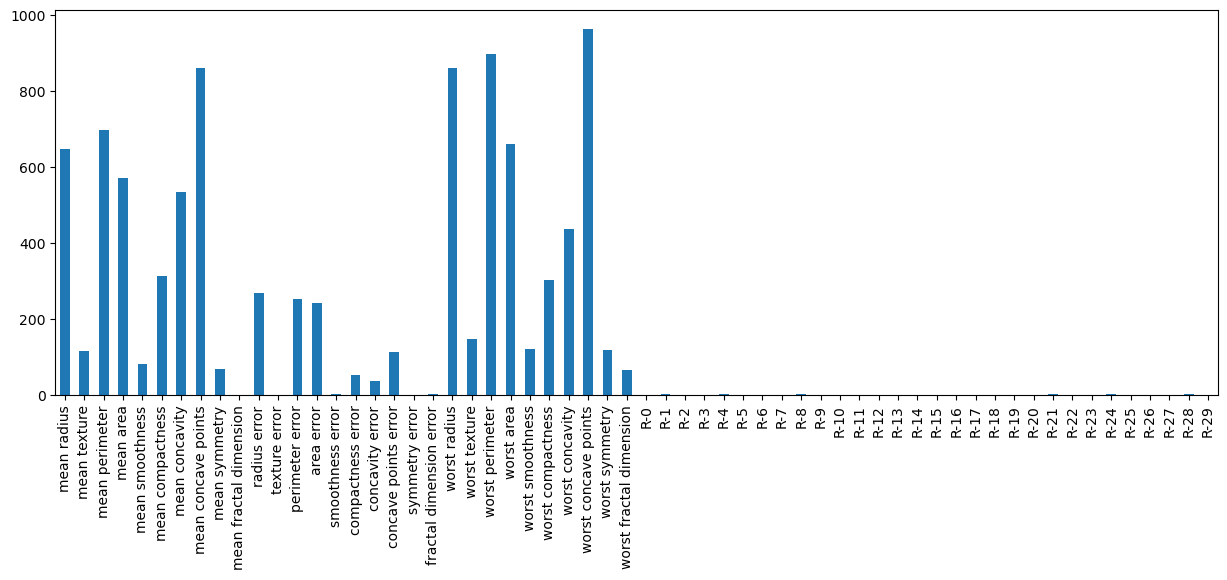

In [28]:
# EJERCICIO: mostrar el grado de relevancia de cada atributo del datastet X_RUIDOSOS mediante el test ANOVA

# Calcular las puntuaciones de relevancia utilizando el test ANOVA
fvalues_ruidosos = f_classif(X_RUIDOSOS, y)[0]

# Llamar a la función muestra_relevancias para visualizar los resultados
muestra_relevancias(X_RUIDOSOS.columns, fvalues_ruidosos)


In [12]:
# EJERCICIO: mostrar la selección de la primera mitad de atributos (el 50% mejor) para X según el test ANOVA

# Calcular las puntuaciones de relevancia utilizando el test ANOVA
scores_anova = f_classif(X, y)[0]

# Obtener los índices de los atributos ordenados por puntuaciones de relevancia descendentes
indices_ordenados = np.argsort(scores_anova)[::-1]

# Seleccionar la primera mitad de atributos
num_atributos_seleccionados = len(X.columns) // 2
atributos_seleccionados = X.columns[indices_ordenados[:num_atributos_seleccionados]]

# Mostrar los atributos seleccionados
print("Atributos seleccionados según el test ANOVA (50% mejor):")
for atributo in atributos_seleccionados:
    print(atributo)


Atributos seleccionados según el test ANOVA (50% mejor):
worst concave points
worst perimeter
mean concave points
worst radius
mean perimeter
worst area
mean radius
mean area
mean concavity
worst concavity
mean compactness
worst compactness
radius error
perimeter error
area error


In [30]:
# EJERCICIO: mostrar la selección de la primera mitad de atributos (el 50% mejor) para X_RUIDOSOS según el test ANOVA

'''
# Calcular las puntuaciones de relevancia utilizando el test ANOVA
scores_anova_ruidosos = f_classif(X_RUIDOSOS, y)[0]

# Obtener los índices de los atributos ordenados por puntuaciones de relevancia descendentes
indices_ordenados_ruidosos = np.argsort(scores_anova_ruidosos)[::-1]

# Seleccionar la primera mitad de atributos
num_atributos_seleccionados_ruidosos = len(X_RUIDOSOS.columns) // 2
atributos_seleccionados_ruidosos = X_RUIDOSOS.columns[indices_ordenados_ruidosos[:num_atributos_seleccionados_ruidosos]]

# Mostrar los atributos seleccionados
print("Atributos seleccionados según el test ANOVA para X_RUIDOSOS (50% mejor):")
for atributo in atributos_seleccionados_ruidosos:
    print(atributo)
'''

selector = SelectPercentile(f_classif, percentile=50)
selector.fit(X,y)

mascara = selector.get_support()

s = muestra_seleccion(X.columns_values, mascara)


AttributeError: 'DataFrame' object has no attribute 'columns_values'

In [14]:
# EJERCICIO: mostrar la selección de los 10 mejores atributos para X según el test ANOVA

# Calcular las puntuaciones de relevancia utilizando el test ANOVA
scores_anova = f_classif(X, y)[0]

# Obtener los índices de los atributos ordenados por puntuaciones de relevancia descendentes
indices_ordenados = np.argsort(scores_anova)[::-1]

# Seleccionar los 10 mejores atributos
num_atributos_seleccionados = 10
atributos_seleccionados = X.columns[indices_ordenados[:num_atributos_seleccionados]]

# Mostrar los atributos seleccionados
print("Los 10 mejores atributos seleccionados según el test ANOVA para X:")
for atributo in atributos_seleccionados:
    print(atributo)


Los 10 mejores atributos seleccionados según el test ANOVA para X:
worst concave points
worst perimeter
mean concave points
worst radius
mean perimeter
worst area
mean radius
mean area
mean concavity
worst concavity


In [18]:
# EJERCICIO: 
#   - Obtener una matriz X_RUIDOSOS_seleccion con los 30 mejores atributos del dataset X_RUIDOSOS según ANOVA
#   - Guardar el resultado con:
#          RESULTADOS.loc['ANOVA - 30'] = experimento_seleccion(selector, X, X_RUIDOSOS, y)

from sklearn.feature_selection import SelectKBest

# Definir el estimador SelectKBest con k=20 para seleccionar los 20 mejores atributos
selector = SelectKBest(f_classif, k=20)

# Calcular las puntuaciones de relevancia utilizando el test ANOVA para X_RUIDOSOS
scores_anova_ruidosos = f_classif(X_RUIDOSOS, y)[0]

# Obtener los índices de los atributos ordenados por puntuaciones de relevancia descendentes
indices_ordenados_ruidosos = np.argsort(scores_anova_ruidosos)[::-1]

# Seleccionar los 30 mejores atributos
num_atributos_seleccionados_ruidosos = 30
atributos_seleccionados_ruidosos = X_RUIDOSOS.columns[indices_ordenados_ruidosos[:num_atributos_seleccionados_ruidosos]]

# Crear la matriz X_RUIDOSOS_seleccion
X_RUIDOSOS_seleccion = X_RUIDOSOS[atributos_seleccionados_ruidosos]

# Guardar el resultado en el dataframe RESULTADOS
RESULTADOS.loc['ANOVA - 30'] = experimento_seleccion(selector, X, X_RUIDOSOS_seleccion, y)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [17]:
# EJERCICIO: calcular los resultados del experimento de selección con los 20 mejores atributos según ANOVA

from sklearn.feature_selection import SelectKBest

# Definir el estimador SelectKBest con k=20 para seleccionar los 20 mejores atributos
selector = SelectKBest(f_classif, k=20)

# Seleccionar los 20 mejores atributos
num_atributos_seleccionados_ruidosos = 20
atributos_seleccionados_ruidosos = X_RUIDOSOS.columns[indices_ordenados_ruidosos[:num_atributos_seleccionados_ruidosos]]

# Crear la matriz X_RUIDOSOS_seleccion con los 20 mejores atributos
X_RUIDOSOS_seleccion_20 = X_RUIDOSOS[atributos_seleccionados_ruidosos]

# Guardar el resultado en el dataframe RESULTADOS
RESULTADOS.loc['ANOVA - 20'] = experimento_seleccion(selector, X, X_RUIDOSOS_seleccion_20, y)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

### 2.2. Otros tests disponibles en Sklearn <a name="otros"> </a>
Además del test ANOVA que hemos visto en esta sección, Sklearn proporciona otras funciones de valoración de atributos tanto para tareas de clasificación como de regresión. Para clasificación, las funciones disponibles son:

- <code>f_classif</code>: valor-f del test ANOVA 
- <code>chi2</code>: test $\chi^2$ (solo para atributos positivos)
- <code>mutual_info_classif</code>: información mutua entre dos variables

Para regresión, por su parte, disponemos de estas funciones:

- <code>f_regression</code>: valor-f obtenido mediante regresión lineal
- <code>mutual_info_regression</code>: información mutua entre dos variables

In [19]:
# EJERCICIO: calcular los resultados del experimento de selección con los siguientes selectores
#    'Chi2-30' : con los 30 primeros atributos según chi2
#    'Chi2-20' : con los 20 primeros atributos según chi2
#    'Mutual Info-30' : con los 30 primeros atributos según mutual_info_classif
#    'Mutual Info-20' : con los 20 primeros atributos según mutual_info_classif

from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2

# Definir los selectores y sus parámetros
selectores = {
    'Chi2-30': SelectKBest(chi2, k=30),
    'Chi2-20': SelectKBest(chi2, k=20),
    'Mutual Info-30': SelectKBest(mutual_info_classif, k=30),
    'Mutual Info-20': SelectKBest(mutual_info_classif, k=20)
}

# Calcular los resultados para cada selector
for nombre_selector, selector in selectores.items():
    if '30' in nombre_selector:
        RESULTADOS.loc[nombre_selector] = experimento_seleccion(selector, X, X_RUIDOSOS, y)
    elif '20' in nombre_selector:
        # Para el caso de 20 atributos, utilizamos X_RUIDOSOS_seleccion_20 que fue previamente calculado
        RESULTADOS.loc[nombre_selector] = experimento_seleccion(selector, X, X_RUIDOSOS_seleccion_20, y)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

## 3. Selección de atributos basada en estimadores <a name="estimadores"> </a>

Algunos algoritmos de clasificación (y también de regresión), además de construir un modelo, son capaces de puntuar la importancia de los atributos al mismo tiempo. Esa puntuación es un buen indicador para determinar qué atributos seleccionar. Las dos familias de algoritmos que se suelen usar para esta técnica son:
- Algoritmos basados en árboles: la importancia se calcula sobre el número de veces que se usa cada atributo como criterio y la profundidad en la que aparecen en los árboles.
- Modelos lineales generalizados: la importancia se calcula a partir de los coeficientes aprendidos para cada atributo para construir el modelo.


### 3.1 Selección de atributos mediante árboles <a name="arboles"> </a>

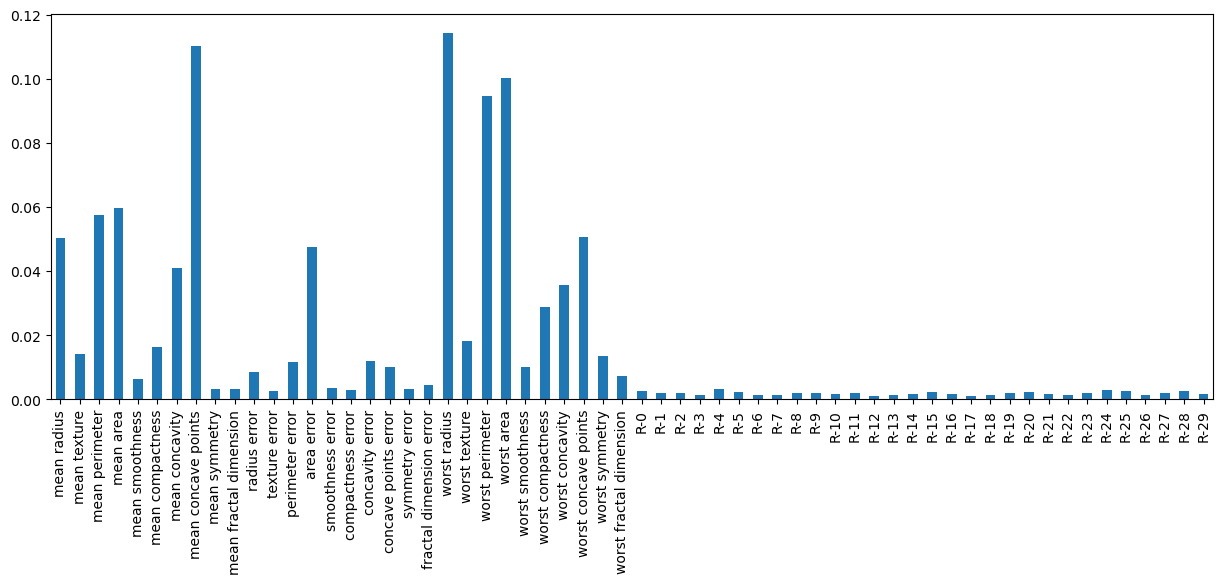

In [20]:
# EJERCICIO: mostrar la importancia de atributos de X_RUIDOSOS calculada por un clasificador RandomForest

from sklearn.ensemble import RandomForestClassifier

# Entrenar un clasificador RandomForest en el dataset X_RUIDOSOS
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_RUIDOSOS, y)

# Obtener la importancia de los atributos
importancias_atributos_rf = clf_rf.feature_importances_

# Mostrar la importancia de los atributos
muestra_relevancias(X_RUIDOSOS.columns, importancias_atributos_rf)


In [23]:
# EJERCICIO: mostrar los atributos de X_RUIDOSOS seleccionados por SelectFromModel sobre el clasificador RFC
#    - Usar como threshold la media de las importancias de atributos

from sklearn.feature_selection import SelectFromModel

# Instanciar y ajustar SelectFromModel
selector = SelectFromModel(clf_rf, threshold='mean', prefit=True)

# Obtener la máscara de atributos seleccionados
mascara_seleccion = selector.get_support()

# Mostrar los nombres de los atributos seleccionados
print("Atributos seleccionados por SelectFromModel sobre el clasificador RandomForestClassifier:")
muestra_seleccion(X_RUIDOSOS.columns, mascara_seleccion)

Atributos seleccionados por SelectFromModel sobre el clasificador RandomForestClassifier:
13 ['mean radius', 'mean perimeter', 'mean area', 'mean concavity', 'mean concave points', 'area error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst compactness', 'worst concavity', 'worst concave points']


In [ ]:
# EJERCICIO: mostrar los atributos de X_RUIDOSOS seleccionados por SelectFromModel sobre el clasificador RFC
#    - Usar como threshold la mitad de la media de las importancias de atributos

# Calcular la media de las importancias de atributos obtenidas del clasificador RFC
media_importancias = np.mean(importancias_atributos_rf)

# Definir el umbral como la mitad de la media
umbral = media_importancias / 2

# Instanciar y ajustar SelectFromModel con el umbral definido
selector = SelectFromModel(clf_rf, threshold=umbral, prefit=True)

# Obtener la máscara de atributos seleccionados
mascara_seleccion = selector.get_support()

# Mostrar los nombres de los atributos seleccionados
print("Atributos seleccionados por SelectFromModel sobre el clasificador RandomForestClassifier con umbral:", umbral)
muestra_seleccion(X_RUIDOSOS.columns, mascara_seleccion)


In [25]:
# EJERCICIO: mostrar los atributos de X_RUIDOSOS seleccionados por SelectFromModel sobre el clasificador RFC
#    - Usar como threshold la mediana de las importancias de atributos

# Instanciar y ajustar SelectFromModel con el umbral definido
selector = SelectFromModel(clf_rf, threshold='median', prefit=True)

# Obtener la máscara de atributos seleccionados
mascara_seleccion = selector.get_support()

# Mostrar los nombres de los atributos seleccionados
print("Atributos seleccionados por SelectFromModel sobre el clasificador RandomForestClassifier con umbral:", umbral)
muestra_seleccion(X_RUIDOSOS.columns, mascara_seleccion)


Atributos seleccionados por SelectFromModel sobre el clasificador RandomForestClassifier con umbral: 0.002956434459743744
30 ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'perimeter error', 'area error', 'smoothness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension', 'R-4', 'R-24']


In [ ]:
# EJERCICIO: calcular los resultados del experimento de selección con los siguientes selectores
#    'Random Forest - mean' : con los atributos que superen la media de la importancia de un clasificador Random Forest
#    'Random Forest - median' : con los atributos que superen la mediana de la importancia de un clasificador Random Forest
#    'Random Forest - 15' : con los 15 mejores atributos según la importancia de un clasificador Random Forest


### 3.2. Selección de atributos mediante coeficientes de modelos lineales <a name="coeficientes"> </a>

In [ ]:
# EJERCICIO: mostrar los coeficientes de los atributos de X_RUIDOSOS calculados por LogisticRegression con regularización 'l1'


In [ ]:
# EJERCICIO: mostrar los atributos de X_RUIDOSOS seleccionados por SelectFromModel sobre el clasificador LR('l1')
#    - Usar como threshold la mediana de las importancias de atributos


In [ ]:
# EJERCICIO: calcular los resultados del experimento de selección con los siguientes selectores
#    'L1 - mean' : con los atributos que superen la media de los coeficientes de una regresión logística
#    'L1 - median' : con los atributos que superen la mediana de los coeficientes de una regresión logística
#    'L1 - 15' : con los 15 mejores atributos según los coeficientes de una regresión logística


### 3.3 _Pipelines_ para encadenar selección y clasificación <a name="pipelines"> </a>

Mediante los pipelines se pueden encadenar estimadores que se entrenan de forma conjunta. Si hacemos un <code>predict</code> sobre un pipeline, para los $n-1$ primeros estimadores se aplicará <code>transform</code> y para el último <code>predict</code>.

Los pipelines se comportan a todos los efectos como estimadores pudiéndose, por ejemplo, realizar validación cruzada sobre ellos con <code>cross_val_predict</code> o <code>cross_val_score</code>.

In [ ]:
# EJERCICIO: consrtuir un pipeline con los siguientes componentes:
#    - Un selector sobre RFC y usando la mediana como threshold
#    - Un clasificador LogisticRegression
# Guardar en RESULTADOS con la siguiente instrucción:
#      RESULTADOS.loc['RFC+LR'] = (evalua(X,y,pipeline), evalua(X,y,pipeline)-evalua(X,y),evalua(X_RUIDOSOS,y,pipeline), evalua(X_RUIDOSOS,y,pipeline)-evalua(X_RUIDOSOS,y))                                      )


In [ ]:
# EJERCICIO: consrtuir un pipeline con los siguientes componentes:
#    - Un selector sobre LogisticRegression usando la mediana como threshold
#    - Un clasificador RFC
# Guardar en RESULTADOS con la siguiente instrucción:
#      RESULTADOS.loc['LR+RFC'] = (evalua(X,y,pipeline), evalua(X,y,pipeline)-evalua(X,y),evalua(X_RUIDOSOS,y,pipeline), evalua(X_RUIDOSOS,y,pipeline)-evalua(X_RUIDOSOS,y))                                      )


## 4. Extracción de atributos mediante _análisis de componentes principales_ <a name="pca"> </a>

El análisis de componentes principales es es una técnica que permite describir un dataset en términos de nuevos atributos (los componentes) que no estén correlacionados. Cada una de estas nuevas columnas se ordenan por la cantidad de varianza que captura de los datos originales, y esta importancia nos puede servir para quedarnos con un número más pequeño de características.


In [ ]:
# EJERCICIO: calcular los resultados del experimento de selección con los siguientes selectores
#    'PCA - 25' : con los nuevos atributos exraidos con PCA(25)
#    'PCA - 20' : con los nuevos atributos exraidos con PCA(20)
#    'PCA - 15' : con los nuevos atributos exraidos con PCA(15)
#    'PCA - 10' : con los nuevos atributos exraidos con PCA(10)
#    'PCA - 5' : con los nuevos atributos exraidos con PCA(5)


In [ ]:
# EJERCICIO: crear una función que pruebe el efecto de distintos valores de n_components (de 1 a un límite dado)


In [ ]:
# TEST: de la función 'evolucion_n_components' sobre X
evolucion_n_components(X, y, len(X.columns))

# TEST: de la función 'evolucion_n_components' sobre X_RUIDOSOS
evolucion_n_components(X_RUIDOSOS, y, len(X.columns))

In [ ]:
# EJERCICIO: aplicar PCA(10) sobre X_RUIDOSOS y mostrar la proporción de varianza capturada por cada componente


## 5. Selección de atributos por _eliminación recursiva_ <a name="rfe"> </a>

La eliminación recursiva de características (RFE de _recursive feature elimination_) se apoya en un clasificador base al igual que ocurre en la selección mediante importancia de atributos. En este caso los atributos se van descartando uno a uno, dejando fuera el que es peor en cada momento. Es una técnica computacionalmente un pocos costosa (el coste depende del clasificador base) pero suele dar buenos resultados.

In [ ]:
# EJERCICIO: entrenar un selector RFE sobre X usando como clasificador base LogisticRegression, y mostrar el ranking de atributos resultante


In [ ]:
# Función para construir una lista ordenada de los nombres de atributos a partir de un ranking y su correspondiente matriz X
def ranking_nombres_atributos(ranking, nombres_atributos):
    posiciones_atributos = list(zip(ranking, list(nombres_atributos)))
    posiciones_atributos.sort()
    return([a for _,a in posiciones_atributos])

ranking_nombres_atributos(ranking_X, X.columns)

In [ ]:
# Función que prueba el efecto de eliminar uno a uno los peores atributos de una matriz X
def evolucion_quitando_peor_atributo(X, y, selector_rfe):
    ''' Quita uno a uno los peores atributos y evalua el dataset que va quedando
    
    Entrada:
       - X: dataframe con los atributos
       - y: serie con la clase
       - selector_rfe: selector RFE usado
    Salida:
       - Gráfica con la evolución
       - Mejor resultado obtenido
    '''
    selector_rfe.fit(X,y)
    ranking = selector_rfe.ranking_
    resultados = []
    atributos_seleccionados = ranking_nombres_atributos(ranking, X.columns)
    for i in range(len(ranking)):
        #print(atributos_seleccionados[-1])
        X_sel = X[atributos_seleccionados]
        resultado = evalua(X_sel, y)
        resultados.append(resultado)
        atributos_seleccionados = atributos_seleccionados[:-1]
    plt.plot(resultados)
    plt.show()
    return(max(resultados))




In [ ]:
# EJERCICIO: usar la función 'evolucion_quitando_peor_atributo' sobre X y X_RUIDOSOS con un selector RFE basado en LogisticRegression
#   Calcular las siguientes variables:
#      - resultado_X: resultado sobre X sin selección
#      - resultado_X_seleccion: mejor resultado obtenido sobre X en la secuencia de experimentos RFE
#      - resultado_X_RUIDOSOS: resultado sobre X_RUIDOSOS sin selección
#      - resultado_X_RUIDOSOS_seleccion: mejor resultado obtenido sobre X_RUIDOSOS en la secuencia de experimentos RFE
# Guardar en RESULTADOS con la siguiente instrucción:
#      RESULTADOS.loc['RFE - LR'] = (resultado_X_seleccion, resultado_X_seleccion-resultado_X, resultado_X_RUIDOSOS_seleccion, resultado_X_RUIDOSOS_seleccion-resultado_X_RUIDOSOS)


## 6. Conclusiones <a name="conclusiones"> </a>

Las técnicas han funcionado bien para los datos ruidosos, con las siguientes mejoras significativas:
- **Pipeline LR-RFC**: mejora un 3.0%
- **RFE**: mejora un 2.6%
- **Información mutua**: mejora un 1.9%
- **ANOVA**: mejora un 1.9%
- **Random Forest**: mejora a un 1.7%
- **Pipeline RFC-LR**: mejora un 1.7%
- **Coeficientes lineales**: mejora un 1.4%
- **Chi2**: mejora un 1.2%
    
No hay apenas mejora en los datos originales:
- En el caso de los datos ruidosos sabíamos positivamente que había columnas que quitar, por lo que es razonable el resultado.
- Para los datos originanes estos resultados nos están sugiriendo que el conjunto de atributos originales era bastante bueno.

En cuanto a la utilidad y potencia de cada método, no podemos sacar conclusiones generales. En _machine learning_ impera la máxima _one size does not fit all_, y lo que funciona para un dataset no es seguro que funcione para otros.